In [15]:
n_iter=1000

In [16]:
=

In [17]:
=10

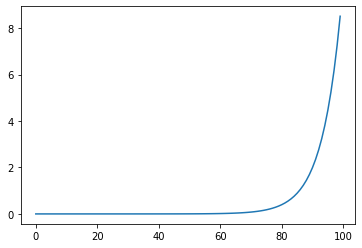

In [39]:
max_iters,min_lr,max_lr=100,1e-6,10
lrs=[]
for n_iter in range(max_iters):
    pos=n_iter/max_iters
#     print( pos)
    lr=min_lr*(max_lr/min_lr)**pos
#     print( f"{lr:.6f}")
    lrs.append(lr)
import matplotlib.pyplot as plt
plt.plot(lrs)
    

In [46]:
def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

C:\Users\HP\.conda\envs\DL12\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\HP\.conda\envs\DL12\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


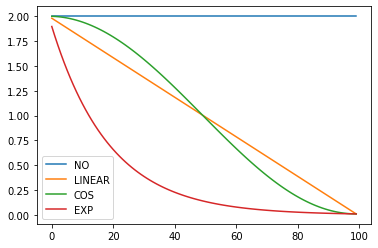

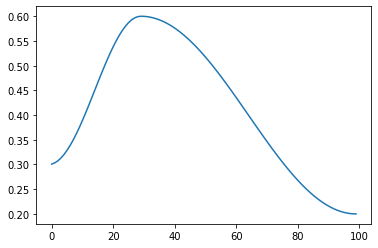

In [47]:
import torch
import torch.tensor as tensor
from functools import partial
import math
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner




annealings = "NO LINEAR COS EXP".split()
a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)
fns = [sched_no, sched_lin, sched_cos, sched_exp]
fig = plt.figure()
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend()
fig.show()
fig = plt.figure()
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
plt.plot(a, [sched(o) for o in p])
fig.show()